In [18]:
import dotenv
dotenv.load_dotenv()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')


In [19]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command

# Define available agents
members = ["web_researcher", "nl2sql"]
# Add FINISH as an option for task completion
options = members + ["FINISH"]

# Create system prompt for supervisor
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Define router type for structured output
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["web_researcher", "nl2sql", "FINISH"]

# Create supervisor node function
def supervisor_node(state: MessagesState) -> Command[Literal["web_researcher", "nl2sql", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END
    return Command(goto=goto)


In [20]:
from typing import Annotated, Any, Dict, Sequence, TypedDict
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}

    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    return graph_builder.compile()


In [21]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=2)

In [22]:
!wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
!mv Chinook_Sqlite.sqlite Chinook.db

--2025-01-30 20:25:11--  https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite [following]
--2025-01-30 20:25:12--  https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1067008 (1.0M) [application/octet-stream]
Saving to: ‘Chinook_Sqlite.sqlite’

Chinook_Sqlite.sqli 100%[===================>]   1.02M  6.74MB/

In [23]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")


In [24]:
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text


In [25]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.tools import tool
from langchain.tools import tool
from pydantic import BaseModel

class SQLToolSchema(BaseModel):
    question: str

@tool(args_schema=SQLToolSchema)
def nl2sql_tool(question):
    """Tool to Generate and Execute SQL Query to answer User Questions related to chinook DB"""
    print("INSIDE NL2SQL TOOL")
    execute_query = QuerySQLDataBaseTool(db=db)
    write_query = create_sql_query_chain(llm, db)

    chain = (
        RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
            result=itemgetter("query") | execute_query
        )
    )

    response = chain.invoke({"question": question})
    return response['result']


In [26]:
question = "How many employees are there?"
result = nl2sql_tool.invoke({"question": question})
print(f"Answer: {result}")

INSIDE NL2SQL TOOL
Answer: [(8,)]


In [37]:
websearch_agent = create_agent(llm, [web_search_tool])

def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    print("INSIDE WEB RESEARCH NODE")
    print(state)
    print("*"*10)
    result = websearch_agent.invoke(state)
    print(result)
    print("*"*20)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )


In [38]:
nl2sql_agent = create_agent(llm, [nl2sql_tool])

def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = nl2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="nl2sql")
            ]
        },
        goto="supervisor",
    )


In [39]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("web_researcher", web_research_node)
builder.add_node("nl2sql", nl2sql_node)
graph = builder.compile()


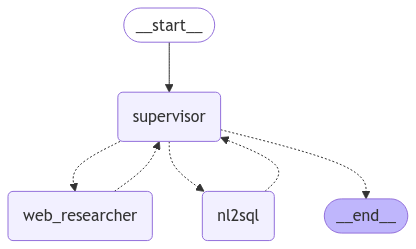

In [40]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
# Example: Complex Query Using Multiple Agents
input_question = "Find the founder of FutureSmart AI and then do a web research on him"
for s in graph.stream(
    {"messages": [("user", input_question)]}, 
    subgraphs=True
):
    print(s)
    print("----")

Next Worker: web_researcher
((), {'supervisor': None})
----
INSIDE WEB RESEARCH NODE
{'messages': [HumanMessage(content='Find the founder of FutureSmart AI and then do a web research on him', additional_kwargs={}, response_metadata={}, id='e1e354bd-ae75-4f45-af60-4110f9c378f0')]}
**********
(('web_researcher:a611dfb0-3793-debc-8c75-ba187c3105e1',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pRneBJKCAuaMFzFOsWTg8eXY', 'function': {'arguments': '{"query":"founder of FutureSmart AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 94, 'total_tokens': 118, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f6